In [ ]:
import torch
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from scipy.special import binom


In [362]:
# multinomial expansion
def multinomial_coeff(params):
    if len(params) == 1:
        return 1
    return binom(sum(params), params[-1]) * multinomial_coeff(params[:-1])

def multinomial( terms, n: int):
    k = terms.shape[-1]
    result = []
    for indices in product(range(n + 1), repeat=k):
        current = 1.0
        if sum(indices) == n:
            coeff = multinomial_coeff(indices)
            for i, index in enumerate(indices):
                current *= terms[i]**(index)
            current *= coeff
            result.append(current)

    # return torch.tensor(result)
    return np.array(result)

# Example usage:
n = 2
a = torch.tensor([2,3, 4, 5, 6,3, 4, 5])
# a = np.array([2,3, 4, 5, 6,3, 4, 5])
multinomial(a, n)

array([25., 40., 16., 30., 24.,  9., 60., 48., 36., 36., 50., 40., 30.,
       60., 25., 40., 32., 24., 48., 40., 16., 30., 24., 18., 36., 30.,
       24.,  9., 20., 16., 12., 24., 20., 16., 12.,  4.], dtype=float32)

В качестве испитуемой функции на данном этапе рассмотрим 
$$ F = \frac{1.25 + cos(5.4y)}{6(1 + (3x-1)^2)}.$$

Посчитаем ее градиент вручную: 

In [269]:
F = lambda x, y : (1.25 + torch.cos(5.4*y))/(6*(1+(3*x-1)**2))
grad_F = lambda x, y : torch.stack([ -((1.25 + torch.cos(5.4*y))/(1+(3*x-1)**2)**2)*(3*x-1) , (-5.4*torch.sin(5.4*y))/(6*(1+(3*x-1)**2))]).T

Тренировочные данные в нашем случае - это точки-значения функции, которые будут использоваться как ближайшие соседи для тестовых точек.

Тестовые данные - это точки на плоскости и значения функции в этих точках. Для проверки точности алгоритма также посчитаем настоящее значение градиента в этих точках.

Простой пример не двумерной функции
$$ F(x_1, x_2, x_3, x_4) = x_1^2+x_2^2+x_3^2+x_4^2 - 1 $$

In [128]:
# func and its gradient
F = lambda x, y, z, t : (x**2+y**2+z**2+t**2 - 1)
grad_F = lambda x, y, z, t : torch.stack([ 2*x, 2*y, 2*z, 2*t]).T

In [243]:
# func and its gradient
F = lambda x, y, z, t : (x*y*z*t)
grad_F = lambda x, y, z, t : torch.stack([ y*z*t, x*z*t,x*y*t , x*y*z ]).T

In [250]:
# func and its gradient
F = lambda x, y, z, t : (torch.sin(x)*torch.cos(y)*torch.sin(z)*torch.cos(t))
grad_F = lambda x, y, z, t : torch.stack([ torch.cos(x)*torch.cos(y)*torch.sin(z)*torch.cos(t),
                                          torch.sin(x)*(-torch.sin(y))*torch.sin(z)*torch.cos(t),
                                          torch.sin(x)*torch.cos(y)*torch.cos(z)*torch.cos(t),
                                          torch.sin(x)*torch.cos(y)*torch.sin(z)*(-torch.sin(t))
                                          ]).T

In [270]:
points = torch.rand([1500,F.__code__.co_argcount])
# x = torch.rand([100,1])
# # y = torch.sqrt(1 - x**2)
# y = torch.zeros_like(x)
# points = torch.cat([x, y], dim=-1)
F_values_args = (points[:, i] for i in range(F.__code__.co_argcount))
F_values = F(*F_values_args)

test_points = torch.rand([20, F.__code__.co_argcount])
test_F_values_args = (test_points[:, i] for i in range(F.__code__.co_argcount))
test_F_values = F(*test_F_values_args)
test_F_values_args = (test_points[:, i] for i in range(F.__code__.co_argcount))
test_grad_F_values = grad_F(*test_F_values_args)

In [275]:
# NNs
nearest = 10
nn = torch.argsort(torch.sqrt(((test_points[:, None, :] - points )**2).sum(axis=-1)), axis=1)[:, :nearest]
meta_indxs = torch.sqrt(((points[nn][:,:,None,:] - points )**2).sum(axis=-1)).argsort(axis=-1)[..., 1:1+11]

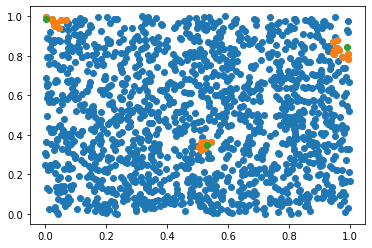

In [278]:
# two-dimensional func
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(points[nn][:3, :, 0],points[nn][:3, :, 1] )
# plt.scatter(points[meta_indxs][:3, :, :, 0],points[meta_indxs][:3, :,:, 1] )
plt.scatter(test_points[:3, 0], test_points[:3, 1])

In [121]:
nn.shape, points[nn].shape, test_points[:, None, :].shape

(torch.Size([20, 8]), torch.Size([20, 8, 4]), torch.Size([20, 1, 4]))

In [150]:
# Least squares
form_A = []
A = (points[nn] - test_points[:, None, :])/(points[nn] - test_points[:, None, :]).norm(dim=-1)[:,:,None]
q = (F_values[nn] - test_F_values[:, None])/(points[nn] - test_points[:, None, :]).norm(dim=-1)
form_A.append(A)

# second order
n = 2
a = torch.ones(F.__code__.co_argcount)
A_2 = torch.zeros([test_points.shape[0], nearest , multinomial(a, n).shape[0]])
for i in range(A_2.shape[0]):
    for j in range(A_2.shape[1]):
        A_2[i][j] = multinomial(A[i][j], n)*(((points[nn] - test_points[:, None, :]).norm(dim=-1)[:,:,None][i][j])**(n-1))/2
print(A_2.shape)
form_A.append(A_2)
print(A.shape)

# third order
n = 3
a = torch.ones(F.__code__.co_argcount)
A_3 = torch.zeros([test_points.shape[0], nearest , multinomial(a, n).shape[0]])
for i in range(A_3.shape[0]):
    for j in range(A_3.shape[1]):
        A_3[i][j] = multinomial(A[i][j], n)*(((points[nn] - test_points[:, None, :]).norm(dim=-1)[:,:,None][i][j])**(n-1))/6
print(A_3.shape)
form_A.append(A_3)

A = torch.cat(form_A, dim=-1)
print(A.shape)

torch.Size([20, 33, 10])
torch.Size([20, 33, 4])
torch.Size([20, 33, 20])
torch.Size([20, 33, 34])


In [151]:
U, S, Vt = torch.linalg.svd(A)
U.shape, S.shape, Vt.shape

(torch.Size([20, 33, 33]), torch.Size([20, 33]), torch.Size([20, 34, 34]))

In [152]:
if A.shape[1] >= A.shape[-1]:
    A_pen = torch.bmm(torch.bmm(Vt.permute((0, 2,1))[:, :, : ], torch.stack([torch.diag((1/S)[i]) for i in range(test_points.shape[0]) ] )), U.permute((0, 2, 1))[:, :A.shape[-1],:])
else:
    A_pen = torch.bmm(torch.bmm(Vt.permute((0, 2,1))[:, :, :A.shape[1]], torch.stack([torch.diag((1/S)[i]) for i in range(test_points.shape[0]) ] )), U.permute((0, 2, 1))[:, :,:])

In [136]:
A_pen.shape, q.unsqueeze(-1).shape, test_grad_F_values.shape

(torch.Size([20, 34, 8]), torch.Size([20, 8, 1]), torch.Size([20, 4]))

In [153]:
((torch.bmm(A_pen, q.unsqueeze(-1)).squeeze(-1))[:, :F.__code__.co_argcount]- test_grad_F_values).norm(p=2, dim=-1)/test_grad_F_values.norm(p=2, dim=-1)

tensor([1.7240e-03, 1.7800e-04, 1.2312e-04, 2.3010e-04, 6.2566e-06, 1.7581e-05,
        1.2237e-04, 3.3023e-04, 1.2842e-04, 9.2854e-05, 2.9290e-05, 8.5914e-05,
        7.1152e-04, 2.0745e-05, 1.7366e-04, 2.5422e-06, 1.6716e-05, 6.3655e-04,
        3.4382e-04, 3.2356e-04])

Scikit-learn datasets, implementations, validations, etc.

In [6]:
# California dataset
from sklearn.datasets import fetch_california_housing
import numpy as np
california_housing = fetch_california_housing()

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from dnnr import DNNR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

alphas = np.logspace(-3, 1, num=30)
# model = make_pipeline(StandardScaler(), DNNR(3, 24))
t = make_pipeline(StandardScaler(), KNeighborsRegressor(15, weights="distance"))
cv_results = cross_validate(
    t,
    california_housing.data,
    california_housing.target,
    return_estimator=True,
    n_jobs=1,
)

In [3]:
score = cv_results["test_score"]
print(f"R2 score: {score.mean():.3f} ± {score.std():.3f}")

R2 score: 0.555 ± 0.037


In [10]:
X = california_housing.data
y = california_housing.target
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

(dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'))

In [13]:
# model = KNeighborsRegressor(13, weights="distance")
m = DNNR(3, 32, scaling=None, precompute_derivatives=True)
m.fit(X_train, y_train)
m.nn_index.fit(X_train)
m.predict(X_test)


fitting index
fited index
quiredod 


IndexError: Vector has wrong length (expected 8, got 32)

In [11]:
m.nn_index.query_knn(X_test[1], 3)

([13768, 6530, 8607],
 [2.3715736865997314, 2.8457491397857666, 3.2773845195770264])

In [264]:
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin

class MyOwnRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, k_neighbors=3, ks_neighbors=5, order=1, device="cpu"):
        self.k_neighbors = k_neighbors
        self.ks_neighbors = ks_neighbors
        self.order = order
        self.device = device
        
    def fit(self, X, y):
        self.features_db = torch.tensor(X, device=self.device, dtype=torch.float64)
        self.labels_db = torch.tensor(y.to_numpy(), device=self.device).unsqueeze(-1)
        self.db_len = self.features_db.shape[0]
        return self
        
    def predict(self, X):
        X = torch.tensor(X, device=self.device, dtype=torch.float64)
        # indecies of k-NN of X
        indxs = torch.sqrt(((X[:, None, :] - self.features_db )**2).sum(dim=-1)).argsort(dim=-1)[..., :self.k_neighbors]
        # indecies of ks-NN of k-NNs of X (for gradient estimation)
        meta_indxs = torch.sqrt(((self.features_db[indxs][:,:,None,:] - self.features_db )**2).sum(dim=-1)).argsort(dim=-1)[..., 1:1+self.ks_neighbors]
        # Construct A and q matrices for LS problem
        A = (self.features_db [meta_indxs] - self.features_db[indxs][:,:, None, :])/(self.features_db[meta_indxs] - self.features_db[indxs][:,:, None, :]).norm(dim=-1)[...,None]
        q = (self.labels_db[meta_indxs] -  self.labels_db[indxs][:,:, None, :])/(self.features_db[meta_indxs] - self.features_db[indxs][:,:, None, :]).norm(dim=-1)[...,None]
        # SVD decomposition
        U, S, Vt = torch.linalg.svd(A)
        # Pseudo-inverse of A
        # Overdetermined case
        print(U.shape, S.shape, Vt.shape, A.shape)
        if A.shape[-2] >= A.shape[-1]:
            A_pen = torch.matmul(
                torch.matmul(Vt.permute((0,1, 3,2)), torch.stack([ torch.stack([torch.diag((1/S)[i][j]) for j in range(self.k_neighbors)]) for i in range(X.shape[0]) ] )),
                U.permute((0,1 ,3, 2))[:,:, :A.shape[-1],:]
            )
        # Underdetermined case
        else:
            A_pen = torch.matmul(
                torch.matmul(Vt.permute((0,1, 3,2))[... , :A.shape[-2]], torch.stack([ torch.stack([torch.diag((1/S)[i][j]) for j in range(self.k_neighbors)]) for i in range(X.shape[0]) ] )),
                U.permute((0,1 ,3, 2))
            )
        # Result
        preds = ((self.labels_db[indxs][..., 0] + ((X[:, None, :] - self.features_db[indxs]) * torch.matmul(A_pen, q).squeeze(-1)).sum(dim=-1)).mean(-1)).numpy()
        # preds = ((self.labels_db[indxs][..., 0] ).mean(-1)).numpy()

        return(preds)
        



In [355]:
l = california_housing.data.to_numpy().shape[0]
train_db = california_housing.data.to_numpy()[:int(0.8*l), :]
test_db = california_housing.data.to_numpy()[int(0.8*l):, :]
train_y = california_housing.target.to_numpy()[:int(0.8*l), None]
test_y = california_housing.target.to_numpy()[int(0.8*l):, None]

In [408]:
indxs = np.sqrt(((test_db[:, None, :] - train_db )**2).sum(axis=-1)).argsort(axis=-1)[:, :20]

In [409]:
meta_indxs = np.sqrt(((train_db[indxs][:,:,None,:] - train_db )**2).sum(axis=-1)).argsort(axis=-1)[..., 1:1+2]

In [410]:
(train_db[meta_indxs]-test_db[:, None, None, :]).shape

(89, 20, 2, 10)

In [418]:
form_A_big = []
A_big = (train_db[meta_indxs] - train_db[indxs][:,:, None, :])/LA.norm((train_db[meta_indxs] - train_db[indxs][:,:, None, :]), axis=-1)[...,None]
q_big = (train_y[meta_indxs] -  train_y[indxs][:,:, None, :])/LA.norm((train_db[meta_indxs] - train_db[indxs][:,:, None, :]), axis=-1)[...,None]
form_A_big.append(A_big)

# second order
# n = 2
# a = np.ones(A_big.shape[-1])
# A_2 = np.zeros([A_big.shape[0], A_big.shape[1] , A_big.shape[2], multinomial(a, n).shape[0]])
# for i in range(A_2.shape[0]):
#     for j in range(A_2.shape[1]):
#         for k in range(A_2.shape[2]):
#             A_2[i][j][k] = multinomial(A_big[i][j][k], n)*((LA.norm((train_db[meta_indxs] - train_db[indxs][:,:, None, :]), axis=-1)[...,None][i][j][k])**(n-1))/2
# print(A_2.shape)
# form_A_big.append(A_2)

A_big = np.concatenate(form_A_big, axis=-1)
print(A_big.shape)

(89, 20, 2, 10)


In [419]:
U, S, Vt = np.linalg.svd(A_big)
A_big.shape, U.shape, S.shape, Vt.shape

((89, 20, 2, 10), (89, 20, 2, 2), (89, 20, 2), (89, 20, 10, 10))

In [420]:
if A_big.shape[-2] >= A_big.shape[-1]:
    A_big_pen = np.matmul(
        np.matmul(Vt.transpose((0,1, 3,2)), np.stack([ np.stack([np.diag((1/S)[i][j]) for j in range(A_big.shape[1])]) for i in range(test_y.shape[0]) ] )),
        U.transpose((0,1 ,3, 2))[:,:, :A_big.shape[-1],:]
    )
else:
    A_big_pen = np.matmul(
        np.matmul(Vt.transpose((0,1, 3,2))[... , :A_big.shape[-2]], np.stack([ np.stack([np.diag((1/S)[i][j]) for j in range(A_big.shape[1])]) for i in range(test_y.shape[0]) ] )),
        U.transpose((0,1 ,3, 2))
    )

In [421]:
(train_y[indxs][..., 0] + (np.matmul(A_big_pen, q_big).squeeze(-1)[:,:, :10]*(test_db[:, None, :]-train_db[indxs])).sum(axis=-1)).mean(-1)

array([166.66648564, 175.40769537,  64.38862179, 112.82006131,
       135.22069224, 108.56986029, 167.39607145, 170.87668813,
       138.74650913, 209.52103116, 101.14796316, 120.97615813,
       195.1064643 , 194.31509228, 252.79262205, 192.76210951,
       143.87915875,  89.83735078, 182.10339225,  98.98423065,
       147.82616937, 134.92747523, 176.31540779, 148.06981736,
       144.79368139, 140.73726451,  97.96219025, 131.85781226,
       120.85441203, 216.57770048,  92.90964814, 151.27097834,
       125.66240112, 111.00264905, 174.50365171, 155.61861357,
       102.70104448, 265.78270554, 103.13190571,  88.09868127,
       129.21975799, 246.18503796, 156.32948918,  89.70994064,
       157.01596602, 116.01559774, 194.99323938, 149.4243755 ,
        99.01041567, 157.8339009 , 167.83792828, 181.63318874,
       283.44779931, 101.79208992, 163.28533025, 167.759409  ,
       193.50443405, 174.76748158, 134.41659833, 210.15784129,
       120.66995577, 182.4923102 , 176.34688491, 187.01

In [422]:
LA.norm((train_y[indxs][..., 0] + (np.matmul(A_big_pen, q_big).squeeze(-1)[:,:, :10]*(test_db[:, None, :]-train_db[indxs])).sum(axis=-1)).mean(-1) - test_y)

8377.577608638883

In [20]:
a = 0.73632
g = 9.18
H = 15
l = 100
k = 2*np.pi/l
v_g = 0.5*(g*a + g*k*(1 - a**2)*H)/(np.sqrt(a*g*k))

In [23]:
v_g

8.22513467830804